# Measurement Error

Measurement error occurs when a variable of interest cannot be measured directly, but we have an imperfect proxy that we can use in its place. 

In HRI, there are many variables that cannot be easily measured. For example, subject trust cannot be measured directly. In practice, trust scales are used as imperfect proxies. We can expect that there will be measurement error when using such proxies. 

In a hypothetical experiment, imagine that we are trying to perform an observational study of some intervention (perhaps a decision support system) on some outcome (perhaps human-system working cohesion). These factors are confounded by the subject's trust, which we cannot measure directly but instead measure imperfectly through a proxy (derived from a survey). For this scenario, we assume all variables are binary, and that the error in the proxy trust is non-differential (meaning that the error rate does not depend on variables other than the true trust).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

from causal_hri import data
from causal_hri import estimators
from ananke.graphs import DAG

We define the following variables:
* A: treatment
* C: proxy confounder (measured trust)
* U: true confounder (latent trust)
* Y: outcome



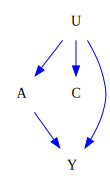

In [2]:
g = DAG(vertices=['A', 'C', 'U', 'Y'],
       di_edges=[('A', 'Y'), ('U', 'A'), ('U', 'Y'), ('U', 'C')]) 
g.draw()

In [3]:
treatment="treatment"
proxy_confounder="measured_trust"
confounder="latent_trust"
outcome="outcome"
n_bootstraps = 50
N = 1000

We adapt the data generation process from H. Oktay, A. Atrey, and D. Jensen, “Identifying when effect restoration will improve estimates of causal effect,” in Proceedings of the 2019 SIAM international conference on data mining, 2019, pp. 190–198.

The data generator depends on four correlation values $\rho_{uc}, \rho_{uy}, \rho_{ua}, \rho_{ay}$, each of which controls the correlations between the variables in our problem.

The data are generated $N$ times as follows:
1. Draw $U$ from $\text{Bern}(0.5)$

2. Draw $p'$ from $\textrm{Uniform}(0, 1)$:

    1. If $p' < \rho_{uc}$ then $C = U$:
    2. Else draw a value $C$ from $\textrm{Bern}(0.5)$
    
3. Draw $p'$ from $\textrm{Uniform}(0,1)$:

    1. If $p' < \rho_{ua}$ then $A = C$
    2. Else draw a value $A$ from $\textrm{Bern}(0.5)$

4. Draw $Y \sim \textrm{Bern}(p(Y=1 | U, A))$ where $p(Y=1 | U, A) = 1 - (1 - \lambda_0)  (1 - \rho_{uy}) ^ U (1 - \rho_{ay})^A$


We compare the following estimators:
* "measurement_error": Implementation of the measurement error estimator as documented in the article. This estimator requires a dataset consisting of (proxy confounder, treatment, outcome) and a separate dataset of (proxy confounder, confounder) with which to estimate the measurement error.
* "naive": The standard inverse probability weighting (IPW) estimator, but where the proxy confounder is incorrectly used in place of the true confounder for adjustment. We should expect this estimator to give biased results.
* "ignore_confounder": Analysis that does not take into account any confounder information (proxy or otherwise).

As a source of truth, we compute IPW again but supply the true confounder:
* "ipw": The standard IPW estimator, where the true confounder is used for adjustment. Note that in practice we would not have the true confounder, only the proxy.




We compute the causal odds ratio on the log scale, which is given by

$$ OR=\log \left(\frac{\frac{p(Y(a=1)=1)}{1 - p(Y(a=1)=1)}}{ \frac{p(Y(a=0)=1 )}{1 - p(Y(a=1)=1 )}}\right)$$

where recall that $Y(A=a)$ is a random variable under the hypothetical intervention where $A$ is set to $a$.

We measure performance by comparing all estimators to $OR_{IPW}$ (which has access to the true confounder and is therefore unaffected by measurement error). For each computed estimate $\hat{OR}$, we compute the relative deviation
$$ (\hat{OR} - OR_{IPW}) / OR_{IPW}$$
and report all results on this scale.

In [13]:
def run_estimators(df, p_uc, N):
    df_proxy = df[["measured_trust", "treatment", "outcome"]]
    df_error = df[["measured_trust", "latent_trust"]]
    est_proxy_all = estimators.estimate_measurement_error(data=df_proxy, data_error=df_error, treatment=treatment, confounder=confounder, proxy_confounder=proxy_confounder, outcome=outcome)
    est_proxy = estimators.compute_log_odds_ratio(p_1_1 = est_proxy_all[1], p_1_0=est_proxy_all[0])
    est_ipw_1 = estimators.estimate_ipw(data=df, outcome="outcome", treatment="treatment", treatment_value=1, confounders=["latent_trust"] ) 
    est_ipw_0 = estimators.estimate_ipw(data=df, outcome="outcome", treatment="treatment", treatment_value=0, confounders=["latent_trust"] )
    est_ipw = estimators.compute_log_odds_ratio(p_1_1 = est_ipw_1, p_1_0 = est_ipw_0)
    reg_model = linear_model.LogisticRegression()
    reg_model = reg_model.fit(X=df_proxy[['treatment']].values, y=df_proxy['outcome'].values)
    est_ignore_1 = reg_model.predict_proba(X=np.ones((1, 1)))[0, 1]
    est_ignore_0 = reg_model.predict_proba(X=np.zeros((1, 1)))[0, 1]
    est_ignore = estimators.compute_log_odds_ratio(p_1_1 = est_ignore_1, p_1_0 = est_ignore_0)
    est_ipw_naive_1 = estimators.estimate_ipw(data=df_proxy, outcome="outcome", treatment="treatment", treatment_value=1, confounders=["measured_trust"] ) 
    est_ipw_naive_0 = estimators.estimate_ipw(data=df_proxy, outcome="outcome", treatment="treatment", treatment_value=0, confounders=["measured_trust"] )
    est_ipw_naive = estimators.compute_log_odds_ratio(p_1_1 = est_ipw_naive_1, p_1_0 = est_ipw_naive_0)
    est_ipw_alternate_1 = estimators.estimate_ipw_binary(data=df, outcome="outcome", treatment="treatment", treatment_value=1, confounder="latent_trust" )

    return {"p_uc": p_uc, "n": N,
                          "measurement_error": (est_proxy - est_ipw)/est_ipw, 
                          "naive": (est_ipw_naive - est_ipw)/est_ipw,
                         "ignore_confounder": (est_ignore - est_ipw)/est_ipw}

In [14]:
p_uc_estimate_list = []
p_uc_list = [.25, .5, .75, 1]
N = 10000
for p_uc in p_uc_list:
    for i in range(n_bootstraps):
        df = data.generate_noisy_or_dataset(N=N, lambda_0=0.01, p_uc=p_uc, p_uy=.5, p_ua=.5, p_ay=.3)
        p_uc_estimate_list.append(run_estimators(df, p_uc, N))

results = pd.DataFrame(p_uc_estimate_list)

melted_results = pd.melt(results, id_vars="p_uc", 
                         value_vars=["measurement_error", "naive", "ignore_confounder"], var_name='Estimator', value_name="Relative Error" )

Below, we consider the impact of the quality of the proxy on adjustment for confounders. As the correlation between latent and measured trust increases, we first note that the estimator ignoring confounding remains biased. The naive estimator (which uses measured trust instead of the true latent trust) improves as the difference between these two diminishes. Finally the measurement error estimator has close to zero error on average, but increasing proxy quality has the benefit of reducing the variance of the estimator.

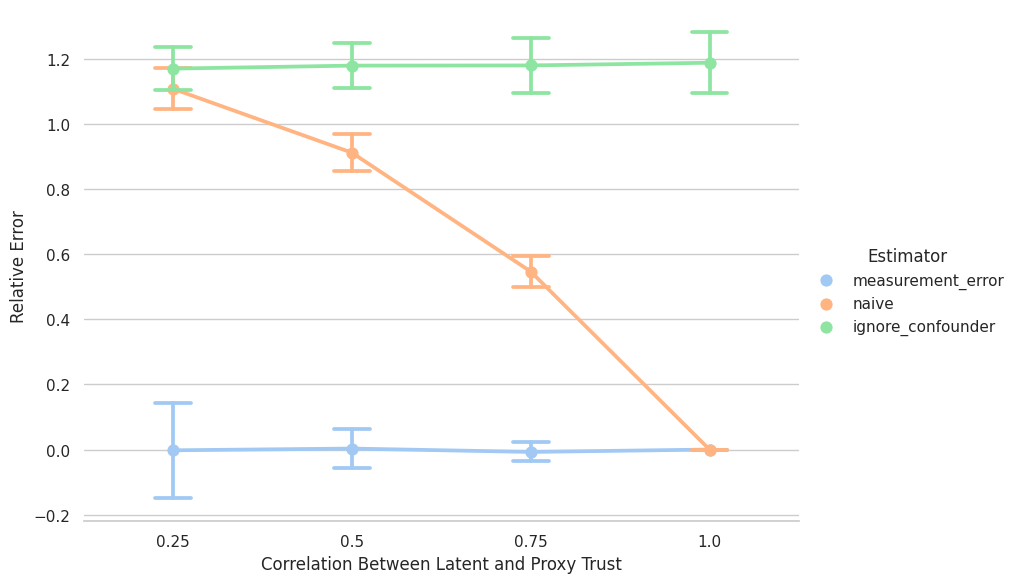

In [15]:
sns.set_theme(style="whitegrid")

g = sns.catplot(x="p_uc", y="Relative Error", hue="Estimator",
                capsize=.2, palette="pastel", height=6, aspect=1.4,
                kind="point", data=melted_results, ci="sd")
g.despine(left=True)
g.set(xlabel='Correlation Between Latent and Proxy Trust')

In [16]:
n_estimates_list = []
p_uc = .5
n_list = [1000, 10000, 100000]
for N in n_list:
    for i in range(n_bootstraps):
        df = data.generate_noisy_or_dataset(N=N, lambda_0=0.01, p_uc=p_uc, p_uy=.5, p_ua=.5, p_ay=.3)
        n_estimates_list.append(run_estimators(df, p_uc, N))

results = pd.DataFrame(n_estimates_list)

melted_results = pd.melt(results, id_vars="n", 
                         value_vars=["measurement_error", "naive", "ignore_confounder"], var_name='Estimator', value_name="Relative Error" )

Below, we hold the various correlations fixed and instead assess the impact of sample size on the various estimators. The key takeaway is that increasing sample sizes does not help with bias if confounding is not correctly adjusted for. Both the naive estimator (incorrectly adjusts using proxy confounder) and the ignoring confounder estimator do not have their bias values going to zero with increasing sample size. In contrast, measurement error estimator error does converge to zero in a consistent manner.

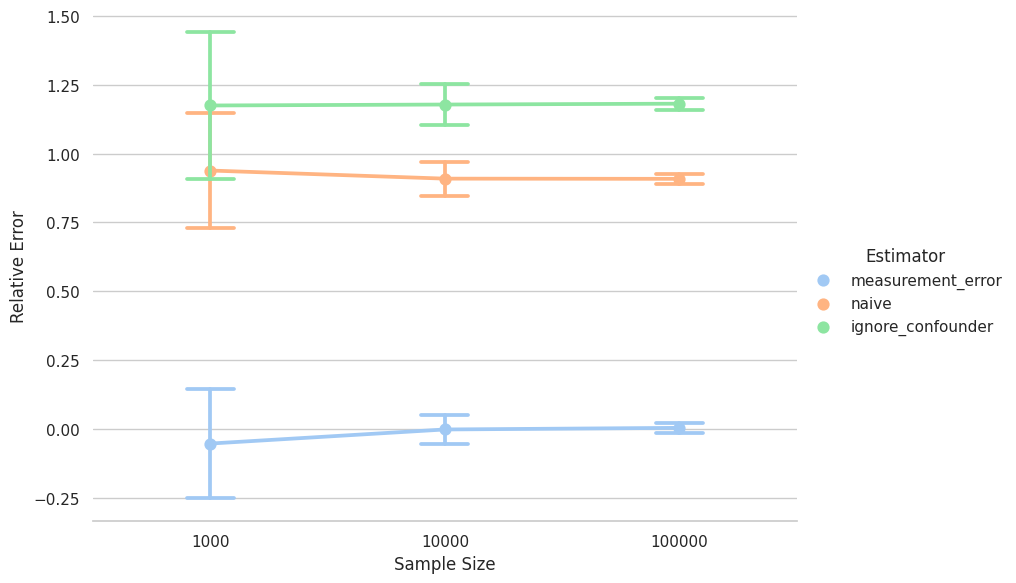

In [18]:
sns.set_theme(style="whitegrid")

g = sns.catplot(x="n", y="Relative Error", hue="Estimator",
                capsize=.2, palette="pastel", height=6, aspect=1.4,
                kind="point", data=melted_results, ci="sd")
g.despine(left=True)
g.set(xlabel='Sample Size')